In [1]:
import numpy as np
import tensorflow as tf
import cv2
from scipy import ndimage
import glob
import os
import scipy
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
GRID_W =4
MODEL_PATH, SAVE_INTERVAL = 'model', 10000
GRID_H =3
LEARNING_RATE = 0.00001

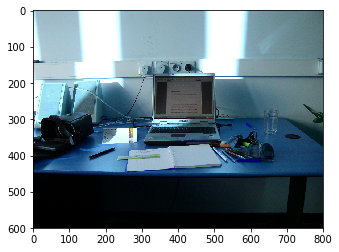

In [3]:
im = np.array(cv2.imread('urban_dataset/urban/P001.TIF'))
plt.imshow(im)

In [4]:
def make_dir(directory):

    if not os.path.exists(directory):
        os.makedirs(directory)

In [6]:
# Initialize the dataset
def load_images():
    all_files = glob.glob('urban_dataset/urban/*.TIF')
    image_data = np.stack([np.array(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)) for filename in all_files])
    all_cover_files = glob.glob('time_covers/*.jpg')
    cover_data = np.stack([np.array(cv2.cvtColor(cv2.resize(cv2.imread(filename), dsize =(280, 373)), cv2.COLOR_BGR2RGB)) for filename in all_cover_files])
    return image_data, cover_data
    
image_data, cover_data= load_images()

In [7]:
def double_images(image_data):
    def get_image(image):
        te=scipy.ndimage.interpolation.rotate(image.copy(), 90)
        res = cv2.resize(te,(800, 600), interpolation = cv2.INTER_AREA)
        return res
    image_data2 = np.stack([np.array(get_image(one_image)) for one_image in image_data])
    return np.concatenate((image_data, image_data2), axis=0)
full_images = double_images(image_data)

In [8]:
full_images.shape

(554, 600, 800, 3)

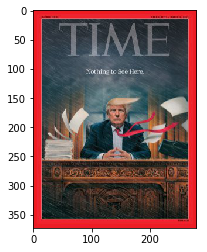

In [18]:
plt.imshow(cover_data[1])

In [19]:
def double_images(image_data):
    cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [20]:
def get_transformed_point(matrix, x, y):
    return matrix[0,0]*x +matrix[0,1]*y +matrix[0,2], matrix[1,0]*x +matrix[1,1]*y +matrix[1,2]

In [21]:
def get_bounding_box(tp1, tp2, tp3, tp4):
    return np.min([tp1[0], tp2[0], tp3[0], tp4[0]]), np.min([tp1[1], tp2[1], tp3[1], tp4[1]]) , np.max([tp1[0], tp2[0], tp3[0], tp4[0]]), np.max([tp1[1], tp2[1], tp3[1], tp4[1]])

In [101]:
int(111/100)

1

In [119]:
def get_label(i, b1, b2, b3, b4, labels):
    center_x = (b1+b3)/2
    center_y = (b2+b4)/2
    grid_lenght_x = 100
    grid_lenght_y = 100

    
    grid_x = int(center_x/100)
    grid_y = int(center_y/100)
    f_x = (center_x-(grid_lenght_x*grid_x))/grid_lenght_x

    grid_y = int(center_y/100)
    f_y = (center_y-(grid_lenght_y*grid_y))/grid_lenght_y
    
    
    grid_num = (grid_y*3)+ grid_x

    width = (b3-b1)/grid_lenght_x
    height = (b4-b2)/grid_lenght_y
    print(grid_x, grid_y,f_x, f_y, width, height)
    #labels[i, grid_y, grid_x,:]= np.array([1, f_x, f_y, width, height])

In [121]:
get_label(1, 100, 100, 150, 150,1)

1 1 0.25 0.25 0.5 0.5


In [23]:
def embedd_covers(i, one_image, small_image, labels):
    #one_image = image_data[24,:,:,:].copy()
    rows,cols,ch = one_image.shape
    resize_factr = 0.4+np.random.random()/3
    img_overlay_rs = cv2.resize(small_image, (0,0), fx=resize_factr, fy=resize_factr)
    # get center
    sy, sx, _ = img_overlay_rs.shape
    # get a random point
    p1x = np.random.randint(sx/2, cols-sx)
    p1y = np.random.randint(sy/2, rows-sy)
    p1 = p1x, p1y
    p2 = p1x+sx, p1y
    p3 = p1x+sx, p1y+sy
    p4 = p1x, p1y+sy
    #print(p1, p2, p3, p4, sx, sy)

    pts1 = np.float32([[p1x, p1y],[p2[0],p2[1]],[p4[0],p4[1]]])
    pts2 = np.float32([[0, 0], [280, 0], [0, 370]])
    m=cv2.getAffineTransform(pts2,pts1)
    dst = cv2.warpAffine(small_image,m,(cols,rows))
    #temp=dst

    center = (p1x+sx/2, p1y+sy/2)
    #print(center)
    matrix = cv2.getRotationMatrix2D(center=center, angle=np.random.randint(-90, 90), scale=1)
    dst = cv2.warpAffine(src=dst, M=matrix, dsize=(800,600))
    #plt.imshow(imagesa)

    tp1 = get_transformed_point(matrix, p1x, p1y)
    tp2 = get_transformed_point(matrix, p2[0],  p2[1])
    tp3 = get_transformed_point(matrix, p3[0],  p3[1])
    tp4 = get_transformed_point(matrix, p4[0],  p4[1])
    #print(tp1, tp2, tp3, tp4)
    
    b1, b2, b3, b4 =get_bounding_box(tp1, tp2, tp3, tp4)
    get_label(i,b1, b2, b3, b4, cols, rows, labels)

    img1 = one_image
    img2 = dst
    #temp = dst
    # I want to put cover on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[0:rows, 0:cols ]
    # Now create a mask of cover and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of cover in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of cover from cover image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put cover in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    img1[0:rows, 0:cols] = dst
    #plt.imshow(small_image)
    #plt.imshow(cv2.rectangle(dst, (int(b1), int(b2)),(int(b3), int(b4)), (255,0,0), 5))
    return dst

In [24]:
def generate_dataset(image_data, cover_data):
    labels =  np.zeros((image_data.shape[0], GRID_H, GRID_W, 5))
    for i in range(image_data.shape[0]):
        image = image_data[i,:,:,:]
        # Select a random cover
        cover = cover_data[np.random.randint(0, cover_data.shape[0]), :, :, :]
        # Embedd the image
        image_data[i,:,:,:]= embedd_covers(i, image, cover, labels)
    return image_data, labels

In [25]:
X, Y =generate_dataset(full_images, cover_data)

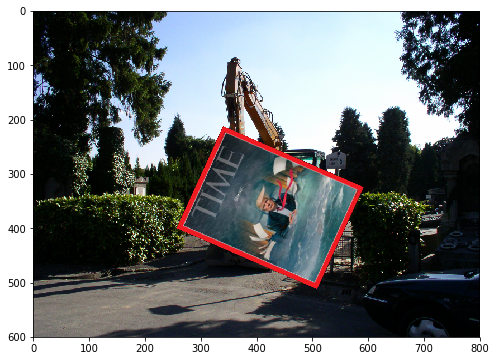

In [26]:
plt.figure(figsize = (8,6))
plt.imshow(X[74],interpolation='nearest', aspect='auto')

In [37]:
Y[74]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.1175    ,  0.8075    ,  1.66389461,  1.49157961],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]])

### Model Creation

In [27]:
def lrelu(x, leak):
    return tf.maximum(x, leak*x, name='relu')

def maxpool_layer(x,size,stride,name):
    with tf.name_scope(name):
        x = tf.layers.max_pooling2d(x, size, stride, padding='SAME')
    return x

def conv_layer(x, kernel, depth, train_logical,name):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        x = tf.layers.conv2d(x, depth, kernel, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(), bias_initializer=tf.zeros_initializer())
        #x = tf.layers.batch_normalization(x, training=train_logical, momentum=0.99, epsilon=0.001, center=True, scale=True)
        #x = lrelu(x, 0.1)
    return x

def passthrough_layer(a, b, kernel, depth, size, train_logical, name):
    b = conv_layer(b, kernel, depth, train_logical,name)
    b = tf.space_to_depth(b, size)
    y = tf.concat([a, b], axis=3)
    return y

In [28]:
Y.shape

(554, 3, 4, 5)

In [29]:
def yolo_net(x, train_logical):
    
    x = conv_layer(x, (3, 3), 32, train_logical, 'conv1')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool1')
    x = conv_layer(x, (3, 3), 64, train_logical, 'conv2')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool2')
    x = conv_layer(x, (3, 3), 128, train_logical, 'conv3')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool22')
    x = conv_layer(x, (1, 1), 128, train_logical, 'conv4')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool52')
    x = conv_layer(x, (3, 3), 256, train_logical, 'conv5')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool5a')
    x = conv_layer(x, (3, 3), 64, train_logical, 'conv5a')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool5b')
    x = conv_layer(x, (3, 3), 64, train_logical, 'conv5b')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool5c')
    x = conv_layer(x, (3, 3), 64, train_logical, 'conv19')
    x = maxpool_layer(x, (2, 2), (2, 2), 'maxpool5s')
    x = conv_layer(x, (3, 3), 30, train_logical, 'conv22a')
    x = conv_layer(x, (3, 3), 5, train_logical, 'conv23aa')

    y = tf.reshape(x, shape=(-1, GRID_H, GRID_W, 5), name='y')

    return y

In [30]:
yolo_net(tf.placeholder(shape = [20, 600, 800, 3], dtype=tf.float32), True).shape

TensorShape([Dimension(20), Dimension(3), Dimension(4), Dimension(5)])

In [31]:
def yolo_loss(pred, lab):
    with tf.name_scope('loss'):
        #lab = np.random.randint(0,2, (3,3,5))
        #pred = np.random.randint(0,2, (3,3,5))
        mask = lab[...,0]
        f_pred = pred[...,0]
        
        mask = tf.cast(mask, tf.bool)
        masked_label = tf.boolean_mask(lab, mask)
        masked_pred = tf.boolean_mask(pred, mask)
        
        
        # Neg Masked Loss
        neg_masked_pred = tf.boolean_mask(f_pred, tf.logical_not(mask))
        neg_masked_loss = tf.reduce_sum(tf.square(tf.cast(neg_masked_pred, tf.float32)))

        # Correct preds loss
        masked_pred_bools = tf.boolean_mask(f_pred, mask)
        masked_pred_loss = tf.reduce_sum(tf.cast(tf.square(masked_pred_bools - 1),tf.float32))
        
        masked_pred_xy = tf.cast(masked_pred[...,1:3], tf.float32)
        masked_pred_wh = tf.cast(masked_pred[...,3:5], tf.float32)
        
        masked_label_xy = tf.cast(masked_label[...,1:3], tf.float32)
        masked_label_wh = tf.cast(masked_label[...,3:5], tf.float32)

        loss_xy = tf.reduce_sum(tf.square(masked_pred_xy-masked_label_xy))
        loss_wh = tf.reduce_sum(tf.square(masked_pred_wh-masked_label_wh))
        
        loss = (0.7*neg_masked_loss)+ masked_pred_loss + ((loss_wh + loss_xy)*10)
        #print(loss_xy.eval())
        return loss

In [32]:
Y_p =np.ones((Y.shape[0], GRID_H,GRID_W, 5))

In [33]:
with tf.Session() as sess:
    print(yolo_loss(Y_p, Y).eval())

9455.39


In [34]:
with tf.Session() as sess:
    lab = np.random.randint(0, 2, size=(1,3,4,5))
    pred = np.random.randint(0, 2, size=(1,3,4,5))
    f_pred = pred[...,0]
    mask = lab[...,0]
    mask = tf.cast(mask, tf.bool)
    masked_label = tf.boolean_mask(lab, mask)
    masked_pred = tf.boolean_mask(f_pred, mask)
    neg_masked_pred = tf.boolean_mask(f_pred, tf.logical_not(mask))
    print(tf.reduce_sum(tf.square(tf.cast(neg_masked_pred, tf.float32))).eval())
    print(tf.reduce_sum(tf.cast(tf.square(masked_pred - 1),tf.float32)).eval())
    

2.0
6.0


In [38]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , data.shape[0])
    np.random.shuffle(idx)
    idx = idx[:num]
    #print(idx)
    data_shuffle = data[idx]
    labels_shuffle = labels[idx]
    #labels_shuffle = np.asarray(labels_shuffle.values.reshape(len(labels_shuffle), 1))

    return data_shuffle, labels_shuffle

In [39]:
def train(X, Y, train_flag, num_iter=2):
    
#     dataset = tf.data.Dataset.from_tensor_slices((X,Y)).batch(8).repeat()
#     itera = dataset.make_one_shot_iterator()
    
    #batch_size = tf.placeholder(tf.int64)
    
    image = tf.placeholder(shape = [None, 600, 800, 3], dtype=tf.float32, name='image_placeholder')
    label = tf.placeholder(shape = [None, GRID_H , GRID_W ,5], dtype=tf.float32, name='label_palceholder')
    
    #dataset = tf.data.Dataset.from_tensor_slices((image, label)).batch(batch_size).repeat(2)
    
    
    train_flag = tf.placeholder(dtype=tf.bool, name='flag_placeholder')
    
    with tf.variable_scope('net'):
        y = yolo_net(image, train_flag)
        
    with tf.name_scope('loss'):
        loss = yolo_loss(y, label)
        
    opt = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    
    train_step = opt.minimize(loss)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    loss_list=[]
    for i in range(num_iter):
        image_data, label_data = next_batch(16,X,Y)
        #print('Iteration Started', image_data.shape)
        _, loss_data, data = sess.run([train_step, loss, y], feed_dict={train_flag: True, image: image_data, label: label_data})
        print ('iter: %i, loss: %f' % (i, loss_data))
        loss_list.append(loss_data)
        
    saver.save(sess, './model.ckpt')
    plt.plot(loss_list)

In [40]:
XX = X/255.
XX = XX.astype('float32')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


iter: 0, loss: 692.934021
iter: 1, loss: 617.929199
iter: 2, loss: 582.045044
iter: 3, loss: 588.094238
iter: 4, loss: 616.224731
iter: 5, loss: 509.712708
iter: 6, loss: 525.690369
iter: 7, loss: 475.843903
iter: 8, loss: 473.219635
iter: 9, loss: 516.153809
iter: 10, loss: 410.241638
iter: 11, loss: 445.171204
iter: 12, loss: 441.496399
iter: 13, loss: 417.115692
iter: 14, loss: 400.513641
iter: 15, loss: 455.015747
iter: 16, loss: 408.719299
iter: 17, loss: 335.392029
iter: 18, loss: 284.017273
iter: 19, loss: 369.099579
iter: 20, loss: 299.911865
iter: 21, loss: 309.727020
iter: 22, loss: 311.582458
iter: 23, loss: 266.848297
iter: 24, loss: 182.582886
iter: 25, loss: 261.817017
iter: 26, loss: 282.428101
iter: 27, loss: 237.939850
iter: 28, loss: 217.716049
iter: 29, loss: 270.199707
iter: 30, loss: 236.014526
iter: 31, loss: 181.208527
iter: 32, loss: 158.944214
iter: 33, loss: 212.985931
iter: 34, loss: 254.730774
iter: 35, loss: 192.449234
iter: 36, loss: 192.086136
iter: 37, l

iter: 304, loss: 62.069839
iter: 305, loss: 68.414902
iter: 306, loss: 58.146729
iter: 307, loss: 80.029335
iter: 308, loss: 73.469604
iter: 309, loss: 83.752098
iter: 310, loss: 70.148148
iter: 311, loss: 95.360703
iter: 312, loss: 97.638016
iter: 313, loss: 105.392906
iter: 314, loss: 91.777824
iter: 315, loss: 70.651932
iter: 316, loss: 85.076729
iter: 317, loss: 63.397266
iter: 318, loss: 76.201920
iter: 319, loss: 46.874081
iter: 320, loss: 68.170364
iter: 321, loss: 72.996994
iter: 322, loss: 67.140854
iter: 323, loss: 62.335979
iter: 324, loss: 53.912514
iter: 325, loss: 87.253098
iter: 326, loss: 64.305939
iter: 327, loss: 70.414673
iter: 328, loss: 49.552170
iter: 329, loss: 45.279839
iter: 330, loss: 52.172562
iter: 331, loss: 68.116341
iter: 332, loss: 67.387718
iter: 333, loss: 86.502281
iter: 334, loss: 76.465286
iter: 335, loss: 43.031567
iter: 336, loss: 51.444725
iter: 337, loss: 48.892963
iter: 338, loss: 66.742973
iter: 339, loss: 60.878647
iter: 340, loss: 48.377594


iter: 608, loss: 37.430950
iter: 609, loss: 46.264702
iter: 610, loss: 62.514954
iter: 611, loss: 39.258675
iter: 612, loss: 39.962467
iter: 613, loss: 52.052368
iter: 614, loss: 50.247677
iter: 615, loss: 66.591278
iter: 616, loss: 55.453514
iter: 617, loss: 54.982216
iter: 618, loss: 59.139648
iter: 619, loss: 57.328892
iter: 620, loss: 47.036278
iter: 621, loss: 46.804577
iter: 622, loss: 43.712128
iter: 623, loss: 49.287376
iter: 624, loss: 61.143669
iter: 625, loss: 51.451370
iter: 626, loss: 46.170372
iter: 627, loss: 56.464783
iter: 628, loss: 37.622154
iter: 629, loss: 51.935692
iter: 630, loss: 46.796318
iter: 631, loss: 60.996063
iter: 632, loss: 59.675964
iter: 633, loss: 61.827850
iter: 634, loss: 74.834183
iter: 635, loss: 46.346268
iter: 636, loss: 52.098522
iter: 637, loss: 43.821976
iter: 638, loss: 49.718975
iter: 639, loss: 53.372341
iter: 640, loss: 51.421562
iter: 641, loss: 53.213894
iter: 642, loss: 36.965130
iter: 643, loss: 59.228302
iter: 644, loss: 57.222012
i

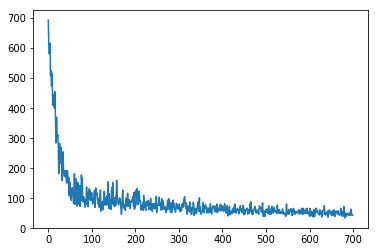

In [41]:
tf.reset_default_graph()
train(XX,Y, True, 700)

In [71]:
def predict(x):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess,'./model.ckpt')
        graph = tf.get_default_graph()
        image = graph.get_tensor_by_name("image_placeholder:0")
        train_flag = graph.get_tensor_by_name("flag_placeholder:0")
        y = graph.get_tensor_by_name("net/y:0")
        data = sess.run(y, feed_dict = {image: [x.copy()], train_flag: True})
        print(np.around(data[0].reshape(12,5), decimals=3))
    return data

In [43]:
Y[22]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.975     ,  0.71      ,  0.91719242,  1.02362227],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]])

INFO:tensorflow:Restoring parameters from ./model.ckpt
[[-0.026       0.78399998  0.66000003  0.64300001  0.72000003]
 [-0.15700001  0.347       1.176       0.84299999  0.90200001]
 [ 0.109       0.35299999  1.20700002  0.81099999  1.14999998]
 [ 0.061       0.14399999  0.71399999  0.773       0.92799997]
 [ 0.032       0.917       0.398       1.12100005  1.03600001]
 [ 0.36300001  0.597       0.62400001  1.34899998  1.18499994]
 [ 0.27500001  0.53799999  0.53299999  1.08800006  1.15100002]
 [ 0.066       0.271       0.52399999  1.10300004  1.171     ]
 [-0.075       0.77999997  0.169       1.16999996  0.97299999]
 [ 0.161       0.44800001  0.22400001  1.39900005  1.26699996]
 [ 0.228       0.505       0.19        1.30999994  1.32000005]
 [ 0.113       0.223       0.192       0.986       1.08299994]]


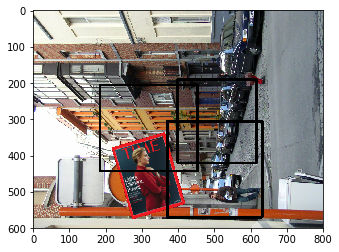

In [97]:
visualize_results(XX[52].copy(), predict(XX[52]))

In [98]:
Y[52]

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 1.        ,  0.5925    ,  0.275     ,  1.0165153 ,  1.19134951],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]])

In [78]:
def visualize_results(temp_image, label):
    #temp_image = embedd_covers(temp_image,small_image)
    imgy, imgx, _ = temp_image.shape
    preds= np.reshape(label[0], newshape=(12, 5))
    
    for i in range(preds.shape[0]):
        grid = preds[i]
        p, px, py, pw, ph = grid
        if p>0.2:
            grid_y = int(i/4)
            grid_x = i-(grid_y*4)
            #print(grid_x, grid_y)
            cx = 200*(grid_x+px)
            cy = 200*(grid_y+py)
            width = 200*pw
            height = 200*ph
            b1 = cx - (width/2)
            b2 = cy - (height/2)
            b3 = cx + (width/2)
            b4 = cy + (height/2)
            #print(b1,b2,b3,b4)
            temp_image = cv2.rectangle(temp_image, (int(b1), int(b2)),(int(b3), int(b4)), (255,0,0), 5)
    plt.imshow(temp_image)

In [121]:
np.reshape(data[0], newshape=(12, 5))

array([[-0.0287969 ,  0.46456429,  0.38654178,  0.5006721 ,  0.39641306],
       [-0.03861443,  0.41967741,  0.82344192,  0.78862715,  0.83698124],
       [ 0.00132587,  0.61501896,  0.75668424,  0.88962823,  0.90668309],
       [ 0.00139699,  0.16549557,  0.30778167,  0.65280747,  0.52411115],
       [ 0.01163563,  1.15062165,  0.48100036,  0.99253058,  0.80988437],
       [ 0.17421135,  0.30379894,  0.60589111,  1.00283408,  0.93095183],
       [ 0.03245914,  0.3773368 ,  0.29263484,  1.04971731,  1.01771557],
       [-0.01256953,  0.14763586,  0.54679406,  0.87921709,  0.95533931],
       [ 0.01377446,  1.06480896,  0.19777328,  0.85134548,  0.88089216],
       [ 0.13514987,  0.47325397,  0.15268998,  1.14273143,  1.07179654],
       [-0.04971713,  0.34339604,  0.15984116,  1.13227642,  1.02150798],
       [-0.03510183,  0.19143026,  0.24426048,  1.01640368,  0.93663198]], dtype=float32)